<a href="https://colab.research.google.com/github/aulphin/GuISE-XAI/blob/main/Evening_medi_guise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/New-Project

[Errno 2] No such file or directory: '/content/drive/MyDrive/New-Project'
/content/drive/MyDrive/Colab Notebooks/New-Project


In [ ]:
!pip install scikit-image scikit-fuzzy

DataSet Preparation

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        # Load a pre-trained ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=True)

        # Freeze the feature layers (optional, depends on your requirement)
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # Replace the classifier of ResNet-50
        # ResNet-50's last layer (fc) output features is 2048
        self.resnet50.fc = nn.Sequential(
            #nn.Linear(2048, 512),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
            nn.Linear(2048, num_classes)  # Output layer for 4 classes
        )

    def forward(self, x):
        return self.resnet50(x)

In [ ]:
# Create an instance of the model for 4 classes
num_classes = 4
model = TumorClassifier(num_classes=num_classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model = model

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/New-Project/best_model.pth'))
model.eval()  # Set the model to evaluation mode
A_model = model

Make a Prediction on Image

In [ ]:
from PIL import Image

def process_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

In [ ]:
import torch

def predict(image_path, model, device):
    image = process_image(image_path)
    image = image.to(device)

    with torch.no_grad():  # No need to track gradients
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        prediction = torch.argmax(probabilities, dim=1)
        return prediction, probabilities

# Example usage
image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/data/meningioma/Te-meTr_0000.jpg'  # Replace with your image path
prediction, probabilities = predict(image_path,A_model, device)
print(f'Predicted Class: {prediction.item()}, Probabilities: {probabilities}')


Predicted Class: 1, Probabilities: tensor([[1.5883e-07, 9.4943e-01, 1.4757e-03, 4.9094e-02]], device='cuda:0')


Guided Mask Part

In [ ]:
from skimage import io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, segmentation
from sklearn.cluster import KMeans
from scipy.stats import mode
from PIL import Image

In [ ]:
# Open the original image and resize it directly
reshaped_image = Image.open('/content/drive/MyDrive/Colab Notebooks/New-Project/data/meningioma/Te-meTr_0000.jpg').resize((224, 224))

# Save the resized image
reshaped_image.save("fixed_img.jpg")


Apply SLIC

In [ ]:
# Load the resized image
original_img = io.imread('fixed_img.jpg')

n_segments = original_img.shape[0] * original_img.shape[1] // 256
segments_slice = slic(original_img, n_segments=n_segments, compactness=10, sigma=1, channel_axis=-1)

# Visualize the segmented image with color boundaries
segmented_img = mark_boundaries(original_img, segments_slice)

Fuzzy C-Means Clustering

In [ ]:
from skimage import io, color
from skimage.filters import rank
from skfuzzy.cluster import cmeans

# Convert the image to grayscale
gray_image = color.rgb2gray(original_img)

# Flatten the image into a 1D array
data = gray_image.flatten()

# Reshape the data into a 2D array (rows x features)
data = data.reshape((-1, 1))

# Specify the number of clusters
num_clusters = 5

In [ ]:
fuzzy_centers, fuzzy_partition_matrix, _, _, _, _, _ = cmeans(data.T, num_clusters, m=2, error=0.005, maxiter=1000)

# Convert the fuzzy partition matrix to a crisp partition matrix
crisp_labels = np.argmax(fuzzy_partition_matrix, axis=0)

# Reshape the labels to the shape of the original image
clustered_image = crisp_labels.reshape(gray_image.shape)

In [ ]:
unique_cmeans_clusters = np.unique(crisp_labels)
print("Unique clusters from Fuzzy c-Means:", unique_cmeans_clusters)

Unique clusters from Fuzzy c-Means: [0 1 2 3 4]


In [ ]:
####### Assigning clusters to each segment #########
import numpy as np
from scipy.stats import mode

# Get the unique segments
unique_segments = np.unique(segments_slice)
print(len(unique_segments))
segment_clusters = {}

# Iterate through each unique segment
for segment in unique_segments:
    # Find the coordinates of pixels belonging to this segment
    coords = np.argwhere(segments_slice == segment)

    # Get the cluster IDs for these pixels
    cluster_ids = [clustered_image[x[0], x[1]] for x in coords]

    mode_result = mode(cluster_ids)
    mode_clusters = mode_result.mode

    # Assign the mode cluster ID to the segment
    segment_clusters[segment] = mode_clusters
    #print(segment_clusters)

152


In [ ]:
# Find the number of unique clusters assigned to segments
unique_assigned_clusters = np.unique(list(segment_clusters.values()))
num_unique_clusters = len(unique_assigned_clusters)

print("Number of unique clusters assigned to segments:", num_unique_clusters)

Number of unique clusters assigned to segments: 5


In [ ]:
# Show the clustered image
# color each cluster to visualize it better
unique_labels = np.unique(crisp_labels)
print(unique_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
#print(colors)
clustered_image_colored = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.float32)
for label, color in zip(unique_labels, colors):
    clustered_image_colored[clustered_image == label] = color[:3]
#clustered_image_colored

[0 1 2 3 4]


In [ ]:
print(clustered_image_colored.shape)

(224, 224, 3)


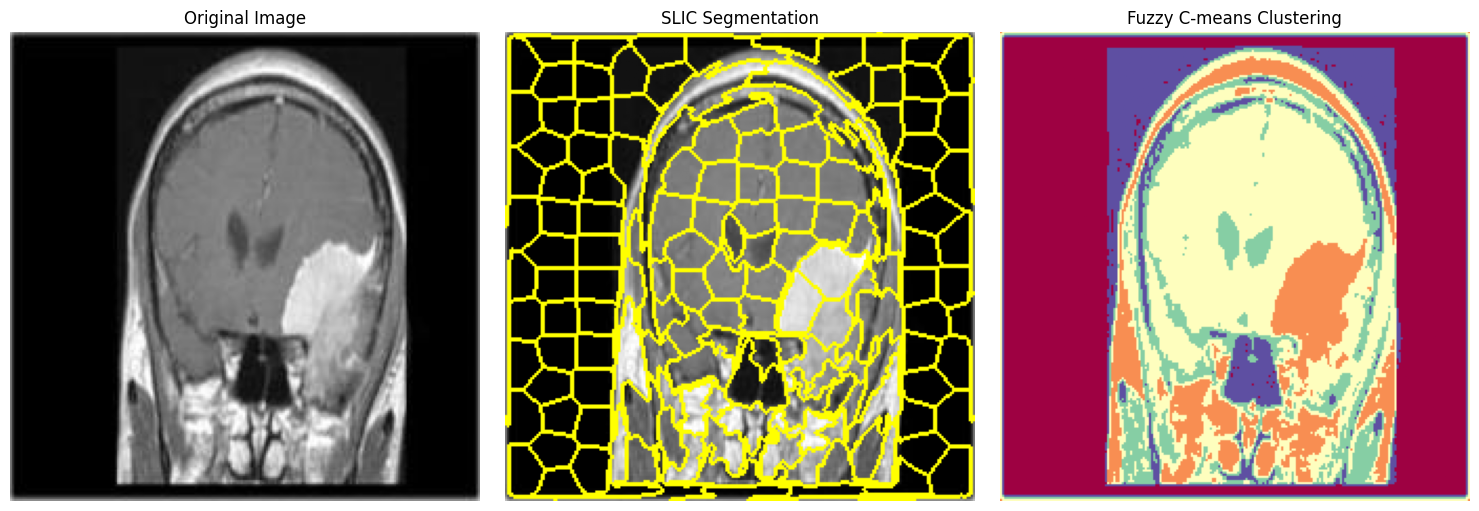

In [ ]:
# Let's plot the original image, the SLIC segmented image, and the FUzzy C-means clustered image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Show SLIC segmented boundaries on the original image
axes[1].imshow(segmented_img)
axes[1].set_title('SLIC Segmentation')
axes[1].axis('off')

axes[2].imshow(clustered_image_colored, extent=(0, original_img.shape[1], original_img.shape[0], 0))
#axes[2].imshow(clustered_image_colored)
axes[2].set_title('Fuzzy C-means Clustering')
axes[2].axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3 4]


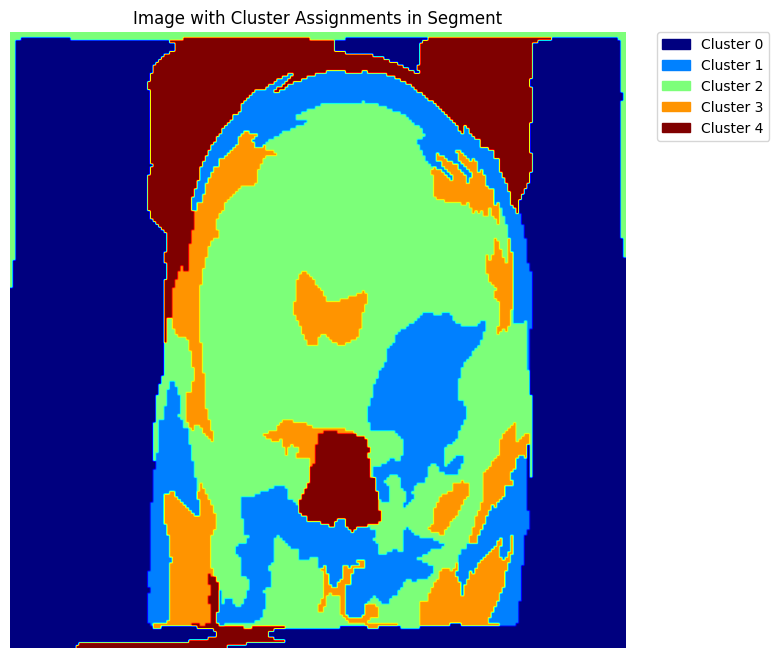

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode


# Create a color map
cmap = plt.cm.jet
norm = plt.Normalize(vmin=clustered_image.min(), vmax=clustered_image.max())

# Initialize a new image array
clustered_segments_img = np.zeros_like(segments_slice)

# Assign cluster colors to each segment
for segment, cluster in segment_clusters.items():
    clustered_segments_img[segments_slice == segment] = cluster



# Plotting the image
plt.figure(figsize=(8, 8))
plt.imshow(clustered_segments_img, cmap=cmap)
plt.title("Image with Cluster Assignments in Segment")
plt.axis('off')  # Hide the axis

# Creating the legend
# Get unique clusters and their colors
unique_clusters = np.unique(clustered_segments_img)
print(unique_clusters)
colors = [cmap(norm(c)) for c in unique_clusters]

# Create a patch for each color
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {int(unique_clusters[i])}') for i in range(len(unique_clusters))]

# Add the legend to the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


In [ ]:
#clustered_segments_img
unique_values = np.unique(clustered_segments_img)
print(unique_values)


[0 1 2 3 4]


Histogram IMplementation

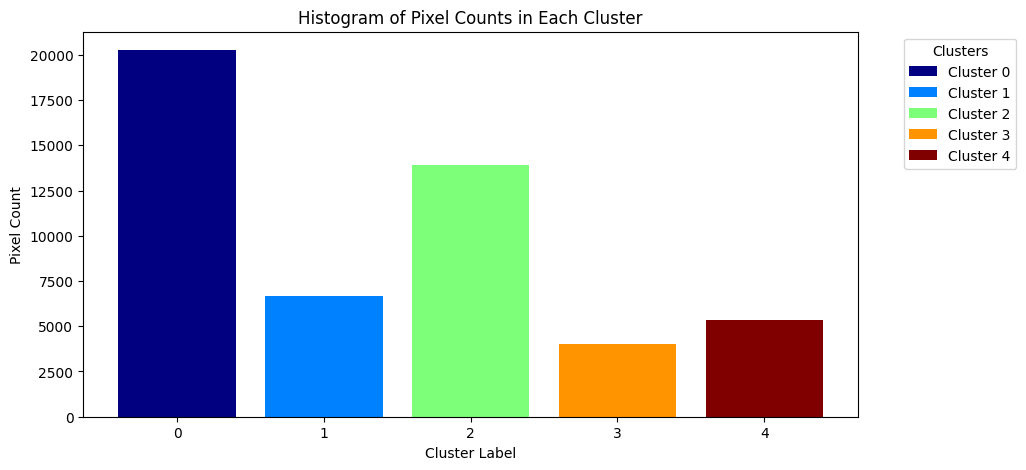

In [ ]:

k=5
# Count the pixels in each cluster
#cluster_pixel_counts = np.bincount(clustered_segments_img, minlength=k)

cluster_pixel_counts = np.bincount(clustered_segments_img.flatten(), minlength=k)
# Create the histogram with colored bars
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(range(0,k), cluster_pixel_counts, color=colors)

# Labeling the axes
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Pixel Count')
ax.set_title('Histogram of Pixel Counts in Each Cluster')
ax.set_xticks(range(0,k))
ax.set_xticklabels(range(0, k))

# Adding a legend to relate colors to clusters
plt.legend(bars, [f'Cluster {i}' for i in range(k)], title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the histogram
plt.show()


In [ ]:
# To compute the percentage of the image each cluster occupies here we have used the total number of pixels in the image
# and the number of pixels in each cluster.

# Total number of pixels in the image
total_pixels = original_img.shape[0] * original_img.shape[1]

# Calculate the percentage of each cluster
cluster_percentages = (cluster_pixel_counts / total_pixels) * 100

# Normalize the values to sum up to 100 and round to 2 decimal places
normalized_percentages = np.round((cluster_percentages / np.sum(cluster_percentages)) * 100, 2)

# Check if the sum is 100 after rounding, if not, adjust the last element to make the sum 100
if np.sum(normalized_percentages) != 100:
    difference = 100 - np.sum(normalized_percentages)
    normalized_percentages[-1] += difference

print(normalized_percentages)
#print(cluster_percentages)

[40.39 13.27 27.69  8.03 10.62]


In [ ]:
# #### New Computation ############3
# # normalized_percentages = np.array([26.32, 65.4, 34.99, 5.61, 11.61])
out =(normalized_percentages / 100)
#print(out)
prob = (1-out)
#print(prob)

#probabilities = np.round(prob, 2)
#print(prob)
probabilities = np.where(out > 0.2, 0.5, np.round(prob, 2))
print(probabilities)

[0.5  0.87 0.5  0.92 0.89]


In [ ]:
cluster_probability_dict = {}
for cluster_label in range(0, min(k + 1, len(probabilities))):
    probability = probabilities[cluster_label]
    cluster_probability_dict[cluster_label] = probability

cluster_probability = {"cluster " + str(cluster_label): probability for cluster_label, probability in cluster_probability_dict.items()}

# Print the result
print(cluster_probability)

{'cluster 0': 0.5, 'cluster 1': 0.87, 'cluster 2': 0.5, 'cluster 3': 0.92, 'cluster 4': 0.89}


Model Call

In [ ]:
from keras.preprocessing import image
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)

    return img, x

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

class Model():
    def __init__(self, pytorch_model):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = pytorch_model
        self.model.to(self.device)

        self.model.eval()  # Set the model to evaluation mode
        self.input_size = (224, 224)
        self.transform = transforms.Compose([
           transforms.Resize((224, 224)),
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

    def run_on_batch(self, x):
        processed_images = []
        for img in x:
            # Convert the image to uint8 if it's not already
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)

            # Convert numpy array to PIL Image
            img_pil = Image.fromarray(img)
            img_transformed = self.transform(img_pil)
            processed_images.append(img_transformed)

        # Stack all processed images into a single tensor and move to the same device as the model
        x_tensor = torch.stack(processed_images).to(self.device)
        with torch.no_grad():
            outputs = self.model(x_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            return probabilities.cpu().numpy()


Guise

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing import image
import random

In [ ]:
# Value Assigning
k=5
clusters = clustered_segments_img
# Define probabilities for each cluster
probabilities = cluster_probability

In [ ]:
import numpy as np
from scipy.stats import mode

def generate_segment_masks(clusters, segments, probabilities):
    unique_segments = np.unique(segments)

    segment_clusters = {}

    # Assign clusters to each segment
    for segment in unique_segments:
        coords = np.argwhere(segments == segment)
        cluster_ids = [clusters[x[0], x[1]] for x in coords]

        mode_result = mode(cluster_ids)
        mode_clusters = mode_result.mode

        segment_clusters[segment] = mode_clusters

    # Initialize an empty mask
    mask = np.zeros_like(segments, dtype=float)
    #print(mask)
     # Count the number of segments for each cluster
    cluster_segment_counts = {}
    for segment, clusters in segment_clusters.items():
        if clusters.size > 0:
            cluster_id = int(clusters)
            if cluster_id in cluster_segment_counts:
                cluster_segment_counts[cluster_id] += 1
            else:
                cluster_segment_counts[cluster_id] = 1

    #print(cluster_segment_counts)
    for cluster_id, segment_count in cluster_segment_counts.items():
    # Get the probability for the current cluster
         cluster_key = f'cluster {cluster_id}'

         if cluster_key in probabilities:
                num_ones = int(probabilities[cluster_key] * segment_count)
                #print(num_ones)
                cluster_segments = [segment for segment, cluster in segment_clusters.items() if cluster == cluster_id]
                #print(cluster_segments)
                selected_segments = random.sample(cluster_segments, num_ones)
                #print(selected_segments)
                # Assign '1' to the selected segments in the mask
                for segment in selected_segments:
                     mask[segments == segment] = 1
    return mask

In [ ]:
result_masks = generate_segment_masks(clustered_image, segments_slice, probabilities)

In [ ]:
# No of mask
N= 256
masks = np.array([generate_segment_masks(clustered_image, segments_slice, probabilities) for _ in range(N)])
print(masks.shape)

(256, 224, 224)


Upto Mask Generation

In [ ]:
batch_size = 50

def explain(model, x, masks):
    preds = []

    masked = np.empty((N, *x.shape))
    #plt.imshow(masked[0])
    for i in range(N):
              masked[i] = x* masks[i, :, :, np.newaxis]
    masked

    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))

    preds = np.concatenate(preds)
    #print("Batch Predictions:", preds[0])
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N
    return sal

In [ ]:
# Example usage
model = Model(A_model)

In [ ]:
img, x = load_img(image_path)

In [ ]:

saliency_maps = explain(model, x, masks)


Explaining: 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


In [ ]:
# Define the mapping of indices to class names
idx_to_cls_names = {0: "Glioma", 1: "Meniongioma",2: "No Tumor", 3: "Pituitary"}

def class_name(idx):
    # Check if the index is within the valid range
    if idx < 0 or idx >= len(idx_to_cls_names):
        return "Invalid index"

    # Return the corresponding class name
    return idx_to_cls_names[idx]

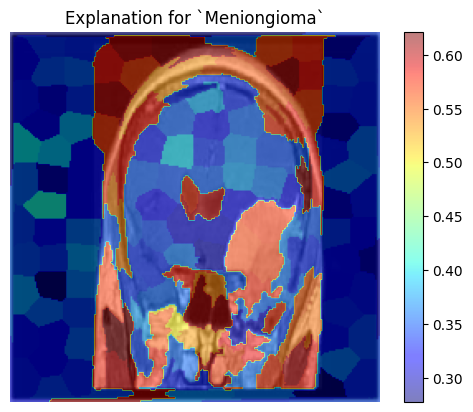

In [ ]:
class_idx = 1
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(saliency_maps[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

Insertion and Deletion Metrics

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project

/content/drive/MyDrive/Colab Notebooks/New-Project


In [ ]:
from evaluation import CausalMetric, auc, gkern
from utils import *

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Wrap the model with a Softmax layer for output probabilities
A_model = nn.Sequential(A_model, nn.Softmax(dim=1))

# Set the model to evaluation mode
A_model.eval()

# Move the model to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A_model.to(device)

# Disable gradient computations for the model
for param in A_model.parameters():
    param.requires_grad = False

# Your A_model is now ready for use


In [ ]:
###### Importing libraries##########
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
cudnn.benchmark = True

In [ ]:
from torch import nn
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

from utils import *

HW = 224 * 224 # image area
n_classes = 4

def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((3, 3, klen, klen))
    kern[0, 0] = k
    kern[1, 1] = k
    kern[2, 2] = k
    return torch.from_numpy(kern.astype('float32'))

def auc(arr):
    """Returns normalized Area Under Curve of the array."""
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)


In [ ]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

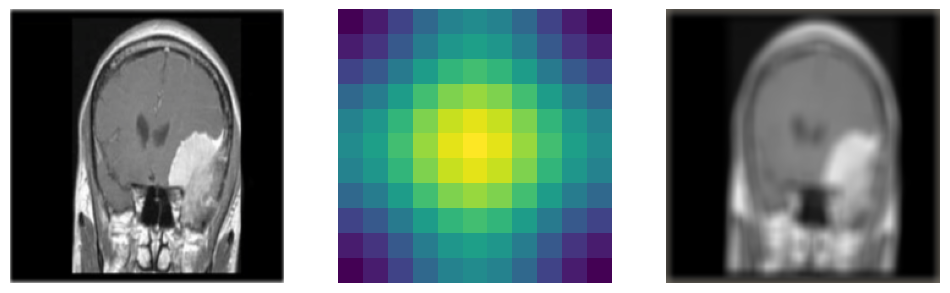

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
#img = read_tensor('/content/drive/MyDrive/New-Project/data/pituitary/Te-piTr_0005.jpg')
img = read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/data/meningioma/Te-meTr_0000.jpg')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [ ]:
class CausalMetric():

    def __init__(self, model, mode, step, substrate_fn):
        r"""Create deletion/insertion metric instance.

        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ['del', 'ins']
        self.model = model
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn

    def single_run(self, img_tensor, explanation, verbose=0, save_to=None):
        r"""Run metric on one image-saliency pair.

        Args:
            img_tensor (Tensor): normalized image tensor.
            explanation (np.ndarray): saliency map.
            verbose (int): in [0, 1, 2].
                0 - return list of scores.
                1 - also plot final step.
                2 - also plot every step and print 2 top classes.
            save_to (str): directory to save every step plots to.

        Return:
            scores (nd.array): Array containing scores at every step.
        """
        #pred = self.model(img_tensor.cuda())
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # self.model = self.model.to(device)
        # img_tensor = img_tensor.to(device)
        pred = self.model(img_tensor.to(device))

        top, c = torch.max(pred, 1)
        c = c.cpu().numpy()[0]
        n_steps = (HW + self.step - 1) // self.step

        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
            start = img_tensor.clone()
            finish = self.substrate_fn(img_tensor)
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
            start = self.substrate_fn(img_tensor)
            finish = img_tensor.clone()

        scores = np.empty(n_steps + 1)
        # Coordinates of pixels in order of decreasing saliency

        salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1)
        for i in range(n_steps+1):
            #start = start.to(device)
            pred = self.model(start.to(device))
            pr, cl = torch.topk(pred, 2)
            # if verbose == 2:
            #     print('{}: {:.3f}'.format(get_class_name(cl[0][0]), float(pr[0][0])))
            #     print('{}: {:.3f}'.format(get_class_name(cl[0][1]), float(pr[0][1])))
            scores[i] = pred[0, c]

            if i < n_steps:
                coords = salient_order[:, self.step * i:self.step * (i + 1)]
                start.cpu().numpy().reshape(1, 3, HW)[0, :, coords] = finish.cpu().numpy().reshape(1, 3, HW)[0, :, coords]



        if verbose == 2 or (verbose == 1 and i == n_steps) or save_to :
                plt.figure(figsize=(10, 5))
                plt.subplot(121)
                plt.title('{} {:.1f}%, P={:.4f}'.format(ylabel, 100 * i / n_steps, scores[i]))
                plt.axis('off')
                tensor_imshow(start[0])

                plt.subplot(122)
                plt.plot(np.arange(i+1) / n_steps, scores[:i+1])
                plt.xlim(-0.1, 1.1)
                plt.ylim(0, 1.05)
                plt.fill_between(np.arange(i+1) / n_steps, 0, scores[:i+1], alpha=0.4)
                plt.title(title,fontsize=16)
                plt.xlabel(ylabel,fontsize=16)
                plt.ylabel(class_name(c),fontsize=16)

                # Increase font size of x and y-axis ticks
                plt.xticks(fontsize=16)  # Adjust fontsize as needed
                plt.yticks(fontsize=16)  # Adjust fontsize as needed

                if save_to:
                    plt.savefig(save_to + '/{:03d}.png'.format(i))
                    plt.close()
                else:
                    plt.show()   # Render image if verbose, if it's the last step or if save is required.

        #print("Final Score:", scores[n_steps])
        print('AUC: {}'.format(auc(scores)))

        return scores

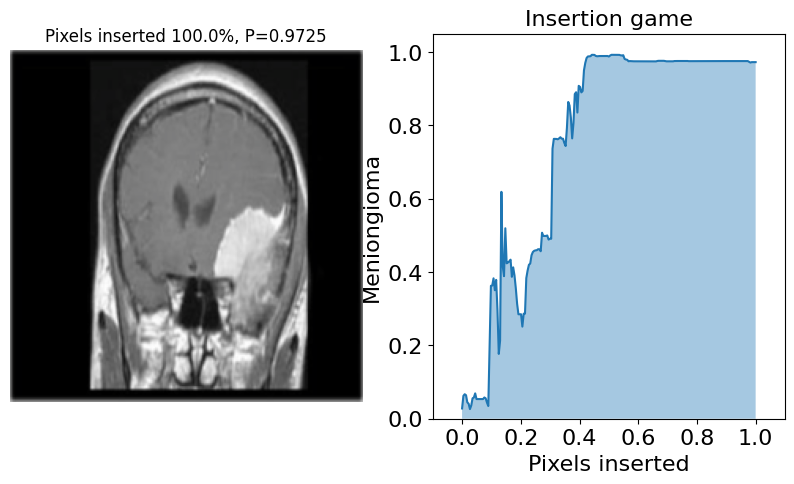

AUC: 0.7514626085217709


In [ ]:
# Assuming A_model is your model instance
model = A_model
model.eval()  # Set the model to evaluation mode

# Instantiate the CausalMetric class
causal_metric = CausalMetric(model, mode='ins', step=224, substrate_fn=blur)

# Run the metric
scores = causal_metric.single_run(img, saliency_maps, verbose=1)

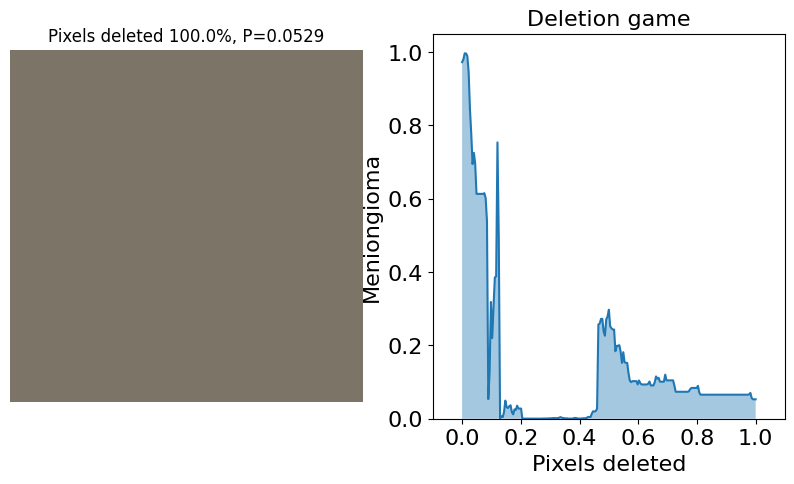

AUC: 0.1391348303211219


In [ ]:
# Assuming A_model is your model instance
model = A_model
model.eval()  # Set the model to evaluation mode

# Instantiate the CausalMetric class
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

# Run the metric
scores = deletion.single_run(img, saliency_maps, verbose=1)
